#Introduction

We took our best model up to now, and we decided to perform all separate predictions, to see if something changes (we thought that the training could not have considered the different ranges of the signals). Unfortunately, this didn't improve our results (almost nothing changed with respect to when the seven time series were trained all together).

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2

/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=ca531cd8e1a7cbc3ff076a18bb54dd3910beb9c6054461bff236117190c77994
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Attention_win90st5_allSeparate_4_LoudnessOnImpact' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


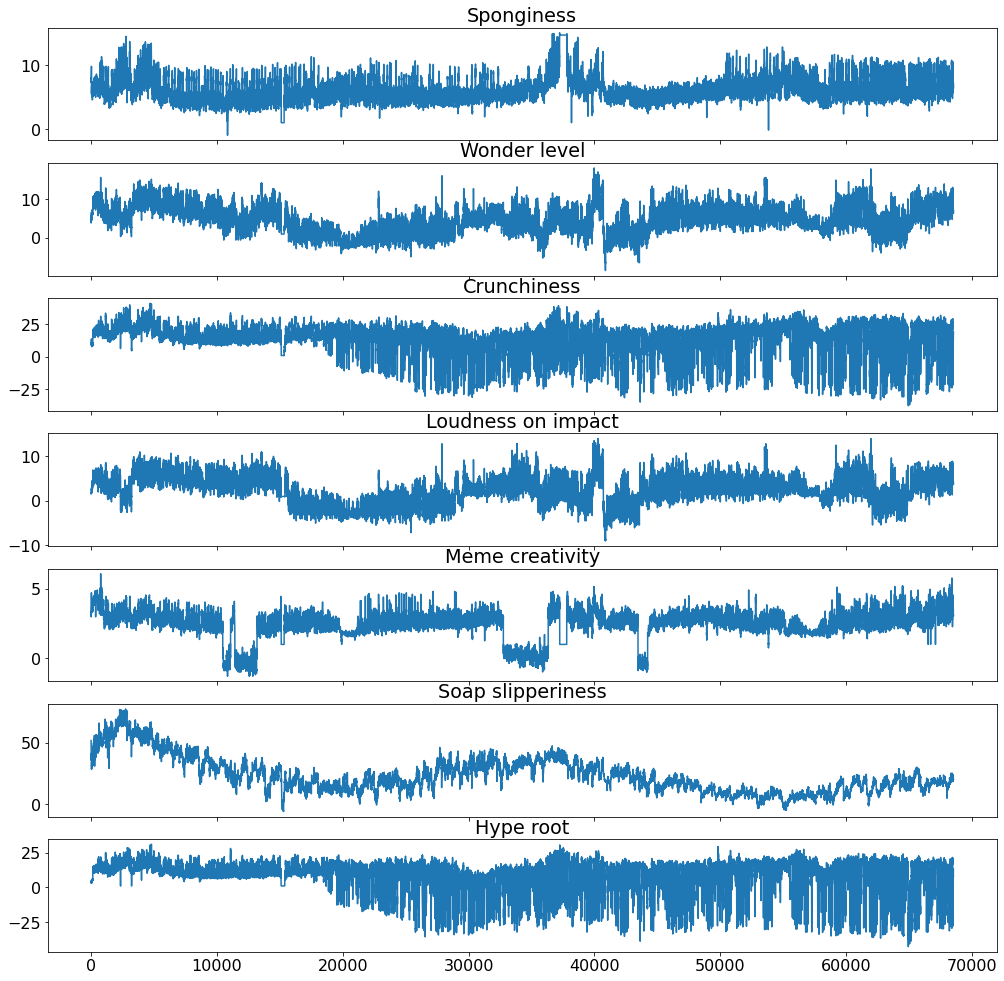

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


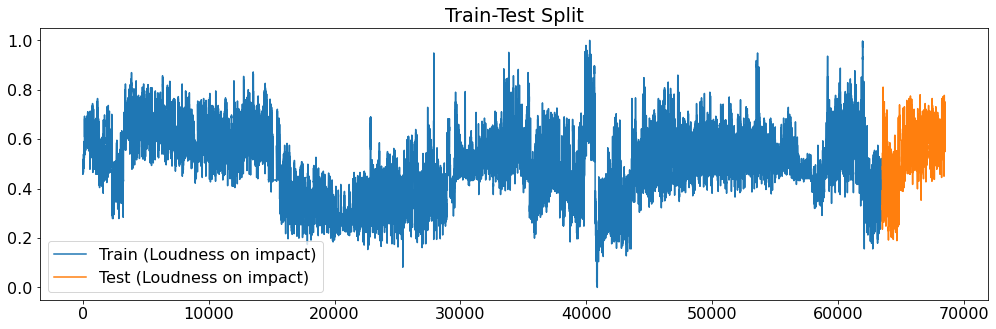

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Loudness on impact'], label='Train (Loudness on impact)')
plt.plot(X_test_raw['Loudness on impact'], label='Test (Loudness on impact)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
future = dataset[-direct_window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
print(future.shape)

(1, 90, 7)


In [ ]:
def build_sequences(df, target_labels=['Loudness on impact'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    index_of_column = 3
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,2))
    #for col in enumerate(columns):
    axs.plot(np.arange(len(X[0,:,index_of_column])), X[idx,:,index_of_column])
    axs.scatter(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), y[idx,:], color='orange')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    print(lstm.shape)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

# Forecasting

In [ ]:
target_labels = ['Loudness on impact']
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12518, 90, 7), (12518, 864, 1), (818, 90, 7), (818, 864, 1))

In [ ]:
#inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 500

In [ ]:
print(input_shape, output_shape)

(90, 7) (864, 1)


(None, 90, 512)
(None, 90, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90, 7)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 90, 512)          540672    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 90, 512)          32833     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 864)               443232    
                             

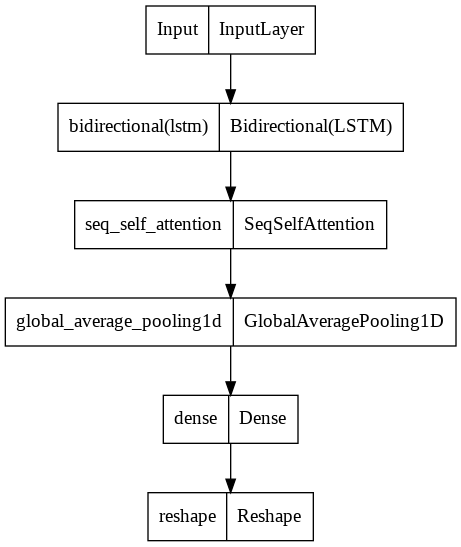

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# restore checkpoints:
#model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0556 - mae: 0.1521 - rmse: 0.2357

1409/1409 [==============================] - 44s 24ms/step - loss: 0.0556 - mae: 0.1521 - rmse: 0.2357 - val_loss: 0.0434 - val_mae: 0.1348 - val_rmse: 0.2083 - lr: 0.0010
Epoch 2/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0347 - mae: 0.1152 - rmse: 0.1862

1409/1409 [==============================] - 33s 24ms/step - loss: 0.0347 - mae: 0.1152 - rmse: 0.1862 - val_loss: 0.0312 - val_mae: 0.1169 - val_rmse: 0.1768 - lr: 0.0010
Epoch 3/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0275 - mae: 0.1026 - rmse: 0.1659

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0275 - mae: 0.1026 - rmse: 0.1659 - val_loss: 0.0280 - val_mae: 0.1116 - val_rmse: 0.1674 - lr: 0.0010
Epoch 4/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0178 - mae: 0.0852 - rmse: 0.1334

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0178 - mae: 0.0852 - rmse: 0.1335 - val_loss: 0.0188 - val_mae: 0.1000 - val_rmse: 0.1372 - lr: 0.0010
Epoch 5/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0137 - mae: 0.0752 - rmse: 0.1172

1409/1409 [==============================] - 33s 24ms/step - loss: 0.0137 - mae: 0.0752 - rmse: 0.1172 - val_loss: 0.0155 - val_mae: 0.0868 - val_rmse: 0.1244 - lr: 0.0010
Epoch 6/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0125 - mae: 0.0710 - rmse: 0.1120

1409/1409 [==============================] - 33s 24ms/step - loss: 0.0125 - mae: 0.0710 - rmse: 0.1120 - val_loss: 0.0154 - val_mae: 0.0892 - val_rmse: 0.1243 - lr: 0.0010
Epoch 7/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0115 - mae: 0.0678 - rmse: 0.1073

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0115 - mae: 0.0678 - rmse: 0.1073 - val_loss: 0.0142 - val_mae: 0.0838 - val_rmse: 0.1190 - lr: 0.0010
Epoch 8/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0108 - mae: 0.0660 - rmse: 0.1040

1409/1409 [==============================] - 33s 24ms/step - loss: 0.0108 - mae: 0.0660 - rmse: 0.1040 - val_loss: 0.0140 - val_mae: 0.0827 - val_rmse: 0.1184 - lr: 0.0010
Epoch 9/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0653 - rmse: 0.1026

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0105 - mae: 0.0653 - rmse: 0.1026 - val_loss: 0.0134 - val_mae: 0.0824 - val_rmse: 0.1159 - lr: 0.0010
Epoch 10/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0635 - rmse: 0.0996

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0099 - mae: 0.0635 - rmse: 0.0996 - val_loss: 0.0139 - val_mae: 0.0833 - val_rmse: 0.1181 - lr: 0.0010
Epoch 11/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0095 - mae: 0.0626 - rmse: 0.0973

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0095 - mae: 0.0626 - rmse: 0.0973 - val_loss: 0.0130 - val_mae: 0.0828 - val_rmse: 0.1140 - lr: 0.0010
Epoch 12/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0615 - rmse: 0.0952

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0091 - mae: 0.0615 - rmse: 0.0952 - val_loss: 0.0129 - val_mae: 0.0815 - val_rmse: 0.1137 - lr: 0.0010
Epoch 13/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0597 - rmse: 0.0898

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0081 - mae: 0.0597 - rmse: 0.0898 - val_loss: 0.0120 - val_mae: 0.0797 - val_rmse: 0.1093 - lr: 0.0010
Epoch 14/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0585 - rmse: 0.0861

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0074 - mae: 0.0585 - rmse: 0.0861 - val_loss: 0.0119 - val_mae: 0.0826 - val_rmse: 0.1092 - lr: 0.0010
Epoch 15/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0584 - rmse: 0.0846

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0072 - mae: 0.0584 - rmse: 0.0846 - val_loss: 0.0108 - val_mae: 0.0774 - val_rmse: 0.1037 - lr: 0.0010
Epoch 16/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0562 - rmse: 0.0811

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0066 - mae: 0.0562 - rmse: 0.0811 - val_loss: 0.0110 - val_mae: 0.0783 - val_rmse: 0.1051 - lr: 0.0010
Epoch 17/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0556 - rmse: 0.0790

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0062 - mae: 0.0556 - rmse: 0.0791 - val_loss: 0.0105 - val_mae: 0.0779 - val_rmse: 0.1024 - lr: 0.0010
Epoch 18/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0538 - rmse: 0.0753

1409/1409 [==============================] - 33s 24ms/step - loss: 0.0057 - mae: 0.0538 - rmse: 0.0753 - val_loss: 0.0105 - val_mae: 0.0773 - val_rmse: 0.1023 - lr: 0.0010
Epoch 19/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0538 - rmse: 0.0756

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0057 - mae: 0.0538 - rmse: 0.0756 - val_loss: 0.0097 - val_mae: 0.0738 - val_rmse: 0.0984 - lr: 0.0010
Epoch 20/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0530 - rmse: 0.0741

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0055 - mae: 0.0530 - rmse: 0.0741 - val_loss: 0.0100 - val_mae: 0.0759 - val_rmse: 0.1001 - lr: 0.0010
Epoch 21/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0527 - rmse: 0.0738

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0054 - mae: 0.0527 - rmse: 0.0738 - val_loss: 0.0103 - val_mae: 0.0777 - val_rmse: 0.1017 - lr: 0.0010
Epoch 22/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0533 - rmse: 0.0737

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0054 - mae: 0.0533 - rmse: 0.0737 - val_loss: 0.0099 - val_mae: 0.0761 - val_rmse: 0.0996 - lr: 0.0010
Epoch 23/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0519 - rmse: 0.0711

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0051 - mae: 0.0519 - rmse: 0.0711 - val_loss: 0.0095 - val_mae: 0.0748 - val_rmse: 0.0977 - lr: 0.0010
Epoch 24/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0509 - rmse: 0.0686

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0047 - mae: 0.0509 - rmse: 0.0686 - val_loss: 0.0097 - val_mae: 0.0762 - val_rmse: 0.0984 - lr: 0.0010
Epoch 25/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0501 - rmse: 0.0672

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0045 - mae: 0.0501 - rmse: 0.0672 - val_loss: 0.0100 - val_mae: 0.0780 - val_rmse: 0.0999 - lr: 0.0010
Epoch 26/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0510 - rmse: 0.0690

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0048 - mae: 0.0510 - rmse: 0.0690 - val_loss: 0.0098 - val_mae: 0.0767 - val_rmse: 0.0988 - lr: 0.0010
Epoch 27/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0509 - rmse: 0.0688

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0047 - mae: 0.0509 - rmse: 0.0688 - val_loss: 0.0110 - val_mae: 0.0826 - val_rmse: 0.1047 - lr: 0.0010
Epoch 28/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0491 - rmse: 0.0657

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0043 - mae: 0.0491 - rmse: 0.0657 - val_loss: 0.0106 - val_mae: 0.0801 - val_rmse: 0.1030 - lr: 0.0010
Epoch 29/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0468 - rmse: 0.0624

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0039 - mae: 0.0468 - rmse: 0.0624 - val_loss: 0.0101 - val_mae: 0.0783 - val_rmse: 0.1005 - lr: 5.0000e-04
Epoch 30/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0464 - rmse: 0.0618

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0038 - mae: 0.0464 - rmse: 0.0618 - val_loss: 0.0109 - val_mae: 0.0811 - val_rmse: 0.1045 - lr: 5.0000e-04
Epoch 31/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0458 - rmse: 0.0608

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0037 - mae: 0.0458 - rmse: 0.0608 - val_loss: 0.0105 - val_mae: 0.0796 - val_rmse: 0.1024 - lr: 5.0000e-04
Epoch 32/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0457 - rmse: 0.0608

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0037 - mae: 0.0457 - rmse: 0.0608 - val_loss: 0.0110 - val_mae: 0.0821 - val_rmse: 0.1048 - lr: 5.0000e-04
Epoch 33/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0451 - rmse: 0.0598

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0036 - mae: 0.0451 - rmse: 0.0598 - val_loss: 0.0107 - val_mae: 0.0808 - val_rmse: 0.1036 - lr: 5.0000e-04
Epoch 34/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0440 - rmse: 0.0584

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0034 - mae: 0.0440 - rmse: 0.0584 - val_loss: 0.0109 - val_mae: 0.0810 - val_rmse: 0.1046 - lr: 2.5000e-04
Epoch 35/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0437 - rmse: 0.0578

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0033 - mae: 0.0437 - rmse: 0.0578 - val_loss: 0.0109 - val_mae: 0.0811 - val_rmse: 0.1042 - lr: 2.5000e-04
Epoch 36/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0436 - rmse: 0.0580

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0034 - mae: 0.0436 - rmse: 0.0580 - val_loss: 0.0111 - val_mae: 0.0816 - val_rmse: 0.1055 - lr: 2.5000e-04
Epoch 37/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0433 - rmse: 0.0575

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0033 - mae: 0.0433 - rmse: 0.0575 - val_loss: 0.0111 - val_mae: 0.0819 - val_rmse: 0.1052 - lr: 2.5000e-04
Epoch 38/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0432 - rmse: 0.0574

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0033 - mae: 0.0432 - rmse: 0.0574 - val_loss: 0.0113 - val_mae: 0.0823 - val_rmse: 0.1063 - lr: 2.5000e-04
Epoch 39/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0032 - mae: 0.0424 - rmse: 0.0562

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0032 - mae: 0.0424 - rmse: 0.0562 - val_loss: 0.0113 - val_mae: 0.0826 - val_rmse: 0.1061 - lr: 1.2500e-04
Epoch 40/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0423 - rmse: 0.0560

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0031 - mae: 0.0423 - rmse: 0.0560 - val_loss: 0.0115 - val_mae: 0.0836 - val_rmse: 0.1073 - lr: 1.2500e-04
Epoch 41/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0031 - mae: 0.0421 - rmse: 0.0557

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0031 - mae: 0.0421 - rmse: 0.0557 - val_loss: 0.0113 - val_mae: 0.0827 - val_rmse: 0.1063 - lr: 1.2500e-04
Epoch 42/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0031 - mae: 0.0420 - rmse: 0.0556

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0031 - mae: 0.0420 - rmse: 0.0556 - val_loss: 0.0113 - val_mae: 0.0827 - val_rmse: 0.1065 - lr: 1.2500e-04
Epoch 43/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0418 - rmse: 0.0553

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0031 - mae: 0.0418 - rmse: 0.0553 - val_loss: 0.0112 - val_mae: 0.0823 - val_rmse: 0.1059 - lr: 1.2500e-04
Epoch 44/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0415 - rmse: 0.0549

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0030 - mae: 0.0415 - rmse: 0.0549 - val_loss: 0.0115 - val_mae: 0.0834 - val_rmse: 0.1070 - lr: 6.2500e-05
Epoch 45/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0415 - rmse: 0.0549

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0030 - mae: 0.0415 - rmse: 0.0549 - val_loss: 0.0114 - val_mae: 0.0833 - val_rmse: 0.1069 - lr: 6.2500e-05
Epoch 46/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0414 - rmse: 0.0547

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0030 - mae: 0.0414 - rmse: 0.0547 - val_loss: 0.0113 - val_mae: 0.0829 - val_rmse: 0.1064 - lr: 6.2500e-05
Epoch 47/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0413 - rmse: 0.0546

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0030 - mae: 0.0413 - rmse: 0.0546 - val_loss: 0.0114 - val_mae: 0.0832 - val_rmse: 0.1068 - lr: 6.2500e-05
Epoch 48/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0412 - rmse: 0.0545

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0030 - mae: 0.0412 - rmse: 0.0545 - val_loss: 0.0114 - val_mae: 0.0830 - val_rmse: 0.1066 - lr: 6.2500e-05
Epoch 49/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0410 - rmse: 0.0543

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0029 - mae: 0.0410 - rmse: 0.0543 - val_loss: 0.0114 - val_mae: 0.0832 - val_rmse: 0.1069 - lr: 3.1250e-05
Epoch 50/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0410 - rmse: 0.0542

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0029 - mae: 0.0410 - rmse: 0.0542 - val_loss: 0.0114 - val_mae: 0.0833 - val_rmse: 0.1070 - lr: 3.1250e-05
Epoch 51/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0410 - rmse: 0.0542

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0029 - mae: 0.0410 - rmse: 0.0542 - val_loss: 0.0114 - val_mae: 0.0833 - val_rmse: 0.1068 - lr: 3.1250e-05
Epoch 52/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0409 - rmse: 0.0541

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0029 - mae: 0.0409 - rmse: 0.0541 - val_loss: 0.0114 - val_mae: 0.0831 - val_rmse: 0.1068 - lr: 3.1250e-05
Epoch 53/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0409 - rmse: 0.0541

1409/1409 [==============================] - 34s 24ms/step - loss: 0.0029 - mae: 0.0409 - rmse: 0.0541 - val_loss: 0.0114 - val_mae: 0.0834 - val_rmse: 0.1069 - lr: 3.1250e-05


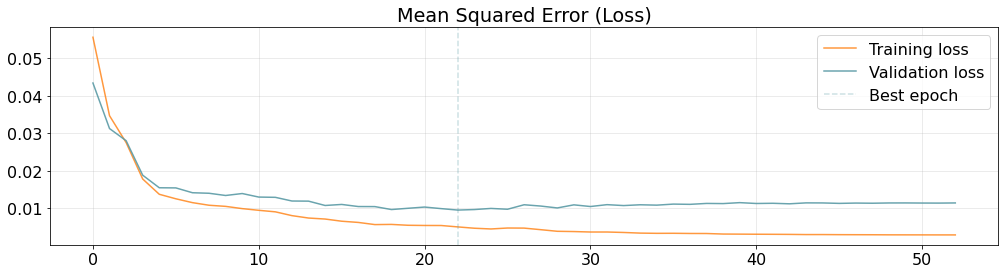

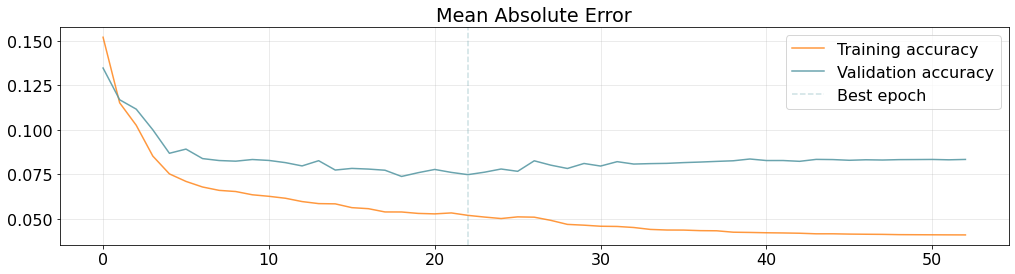

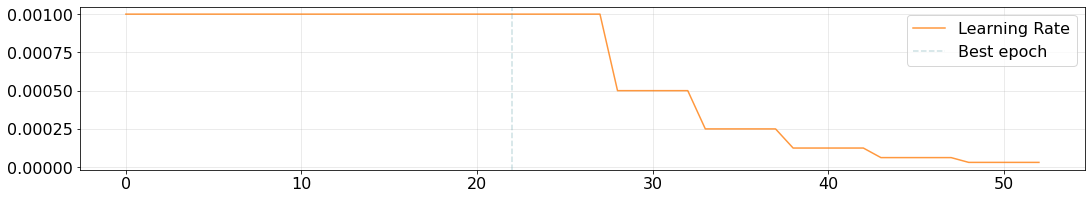

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Models/'+title)
#model = tfk.models.load_model('Models/'+title)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(818, 864, 1)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.009485623>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07616252>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    index_of_column = 3
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,2))
    #for i, col in enumerate(columns):
    axs.plot(np.arange(len(X[0,:,index_of_column])), X[idx,:,index_of_column])
    axs.plot(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), pred[idx,:], color='green')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

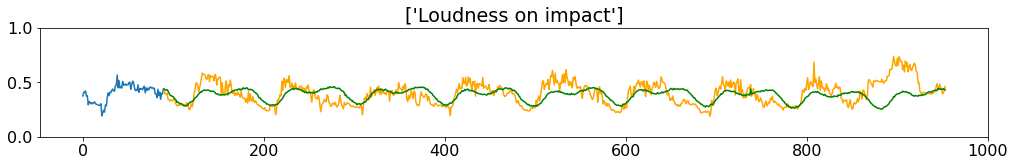

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)